Sanity Check: when model behaviours should overlap
--
*James Hensman and Alexander G. de G. Matthews, 2016*

Many of the model classes in GPflow have overlapping behaviour in special cases. In this section, we fit some approximations to a model with a Gaussian likelihood, and make sure they're all the same. 

The models are:
 - `GPR` full Gaussian process regression
 
 - `VGP` a Gaussian approximation with Variational Bayes
   (approximating a Gaussian posterior with a Gaussian should be exact)
   
 - `SVGP` a sparse GP, with a Gaussian approximation. The inducing points are set to be at the data points, so again, should be exact. 
 
 - `SVGP` (with whitened representation) As above, but with a rotation applied to whiten the representation of the process
 
 - `SGPR` A sparse GP with a *collapsed* posterior (Titsias 2009). Again, the inducing points are fixed to the data points. 
 
 - `GPRFITC` The FITC approximation, again, the inducing points are fixed to the data points.
 
 In all cases the parameters are estimated by the method using maximum likelihood (or approximate maximum likelihood, as appropriate). The parameter estimates should all be the same.

In [4]:
import gpflow
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

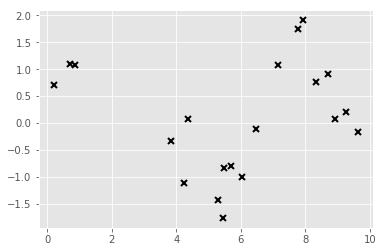

In [5]:
np.random.seed(0)
X = np.random.rand(20,1)*10
Y = np.sin(X) + 0.9 * np.cos(X*1.6) + np.random.randn(*X.shape)* 0.4
Xtest = np.random.rand(10,1)*10
plt.plot(X, Y, 'kx', mew=2)

In [6]:
m1 = gpflow.models.GPR(X, Y, kern=gpflow.kernels.RBF(1))
m2 = gpflow.models.VGP(X, Y, gpflow.kernels.RBF(1), likelihood=gpflow.likelihoods.Gaussian())
m3 = gpflow.models.SVGP(X, Y, gpflow.kernels.RBF(1),
                      likelihood=gpflow.likelihoods.Gaussian(),
                      Z=X.copy(), q_diag=False)
m3.Z.set_trainable(False)
m4 = gpflow.models.SVGP(X, Y, gpflow.kernels.RBF(1),
                      likelihood=gpflow.likelihoods.Gaussian(),
                      Z=X.copy(), q_diag=False, whiten=True)
m4.Z.set_trainable(False)
m5 = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), Z=X.copy())
m5.Z.set_trainable(False)
m6 = gpflow.models.GPRFITC(X, Y, gpflow.kernels.RBF(1), Z=X.copy())
m6.Z.set_trainable(False)
models = [m1, m2, m3, m4, m5, m6]

Now optimize the models. For GPR, SVGP and GPFITC this simply optimizes the hyper-parameters (since the inducing points are fixed). For the variational models, this jointly maximises the ELBO with respect to the variational parameters and the kernel parameters.  

In [7]:
[m.compile() for m in models]
o = gpflow.train.ScipyOptimizer()
_ = [o.minimize(m) for m in models]

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.834361
  Number of iterations: 8
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 18.834362
  Number of iterations: 50
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.543259
  Number of iterations: 11
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22.543259
  Number of iterations: 11
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 18.834400
  Number 

If everything worked as planned, the models should have the same

 - prediction functions
 - log (marginal) likelihood
 - kernel parameters
 
For the variational models, where we use a ELBO in place of the likelihood, the ELBO should be tight to the likelihood in the cases studied here. 

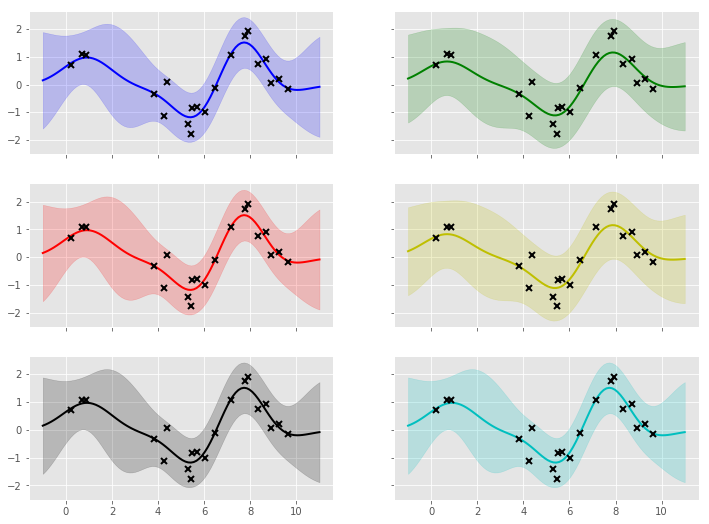

In [8]:
def plot(m, color, ax):
    xx = np.linspace(-1, 11, 100)[:,None]
    mu, var = m.predict_y(xx)
    ax.plot(xx, mu, color, lw=2)
    ax.fill_between(xx[:,0], mu[:,0] -  2*np.sqrt(var[:,0]), mu[:,0] +  2*np.sqrt(var[:,0]), color=color, alpha=0.2)
    ax.plot(X, Y, 'kx', mew=2)

f, ax = plt.subplots(3,2,sharex=True, sharey=True, figsize=(12,9))
plot(m1, 'b', ax[0,0])
plot(m2, 'r', ax[1,0])
plot(m3, 'g', ax[0,1])
plot(m4, 'y', ax[1,1])
plot(m5, 'k', ax[2,0])
plot(m6, 'c', ax[2,1])

Here are the kernels and likelihoods, which show the fitted kernel parameters and noise variance:

In [9]:
from IPython import display
_ = [display.display(m.kern, m.likelihood) for m in models]

Here are the likelihoods (or ELBOs)

In [10]:
print(np.array([m.compute_log_likelihood() for m in models]))

[-18.83436136 -18.83436158 -20.30780316 -20.30780316 -18.83439999
 -18.83435478]
